## Repeat : minibatch, epoch

### Settings

In [1]:
!pip install plotly_express

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score  # accuracy, coefficient of determination

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import plotly_express as px
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
np.random.seed(42)

### Load data

In [5]:
df = pd.read_csv('./flyashes.csv')
df = df.drop("ID", axis=1)
df

,Al2O3,CaO,Fe2O3,SiO2,MgO,Na2O+0.658K2O,SiO2/Al2O3,Amorphous_content,n_c
0,29.5,1.10,4.60,53.8,0.70,1.85000,1.82,72.65,3.38
1,20.7,10.20,7.10,51.4,3.00,1.26000,2.48,78.07,3.09
2,17.8,10.60,7.60,55.3,2.30,1.02000,3.11,73.29,3.11
3,22.8,11.90,3.80,51.6,2.00,0.73000,2.26,73.81,3.09
4,21.6,13.60,4.30,42.9,2.50,8.36000,1.99,84.90,2.97
...,...,...,...,...,...,...,...,...,...
111,20.4,10.60,4.30,42.1,1.09,2.14184,2.06,75.33,NaN
112,21.7,5.80,7.83,54.7,2.13,1.36064,2.52,74.56,NaN
113,22.9,5.45,7.70,55.9,1.80,2.19834,2.44,69.33,NaN
114,21.2,3.90,6.34,62.7,1.46,0.79012,2.96,79.78,NaN


In [6]:
df.describe().to_csv('df.describe().csv')

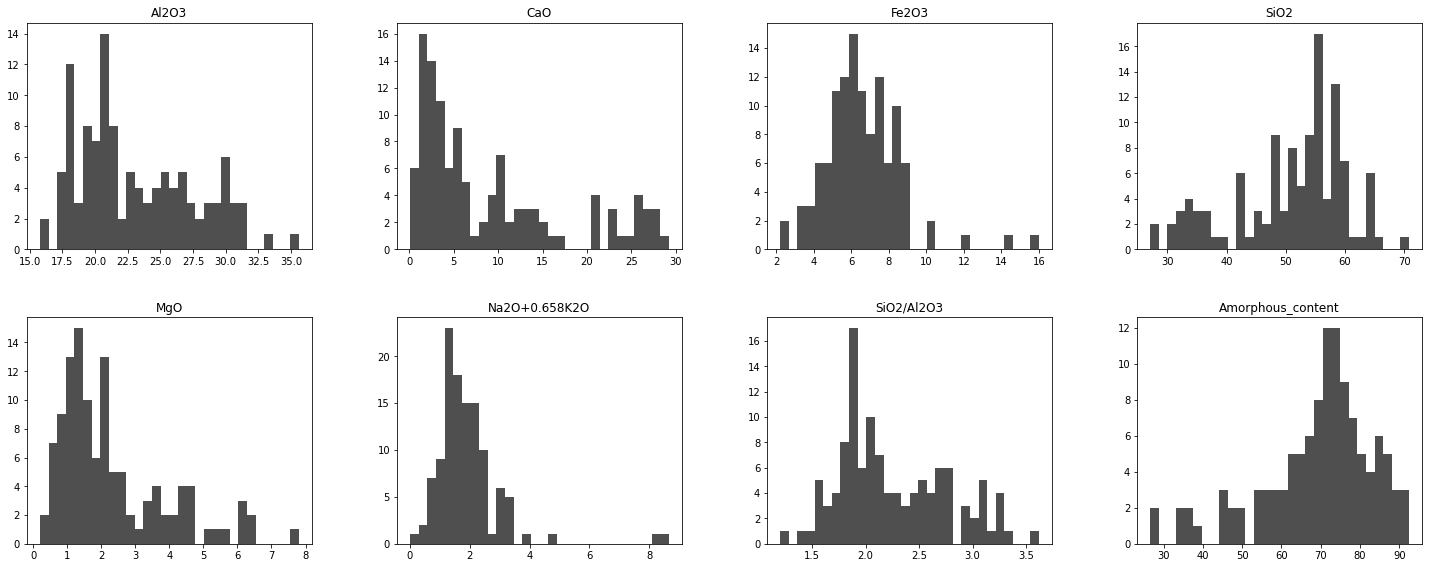

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt

df.drop("n_c", axis=1).hist(bins=30, figsize=(25,15), color='#4F4F4F', grid=False, layout=(3,4))
# plt.tight_layout()
# plt.show()
plt.savefig('./distrb2.png')

### Deeply check data

#### 1. Stratified sampling

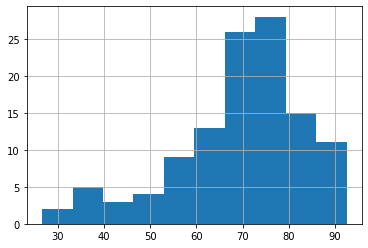

In [8]:
df['Amorphous_content'].hist()

3    25
1    24
2    23
5    22
4    22
Name: Amorphous_cat, dtype: int64


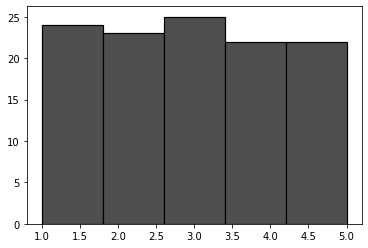

In [9]:
dist = [0.,
        df['Amorphous_content'].quantile(0.2),
        df['Amorphous_content'].quantile(0.4),
        df['Amorphous_content'].quantile(0.6),
        df['Amorphous_content'].quantile(0.8),
        np.inf]

df['Amorphous_cat'] = pd.cut(df['Amorphous_content'], 
                                     bins=dist, 
                                     labels=[1,2,3,4,5])
print(df['Amorphous_cat'].value_counts())
df['Amorphous_cat'].hist(color='#4F4F4F', grid=False, bins=5, edgecolor='black', linewidth=1.2)

In [10]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.145, random_state=42)

for train_idx, test_idx in split.split(df, df["Amorphous_cat"]):
    strat_train = df.loc[train_idx]
    strat_test = df.loc[test_idx]

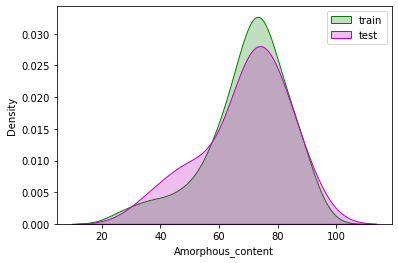

In [11]:
# Stratified Sampling
sns.kdeplot(strat_train['Amorphous_content'], color="g", fill=True, label="train")
# sns.kdeplot(df.loc[idx_val, col], color="c", fill=True, ax=ax, label="val.")
sns.kdeplot(strat_test['Amorphous_content'], color="m", fill=True,  label="test")
plt.legend()
# plt.show()

plt.savefig('./stratified_sampling.png')

Comparing to random sampling.

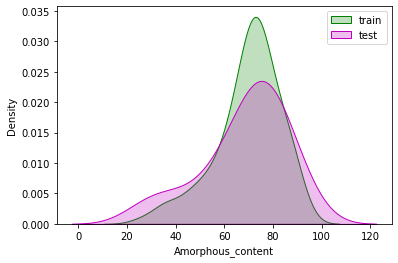

In [12]:
# (vs.) Ordinary Sampling
x_train, x_test, y_train, y_test = train_test_split(df, df['Amorphous_content'], 
                                                      test_size=0.145, shuffle=True, random_state=42) # stratify=target,

sns.kdeplot(y_train, color="g", fill=True, label="train")
sns.kdeplot(y_test, color="m", fill=True,  label="test")
plt.legend()
# plt.show()

plt.savefig('sampling.png')

In [13]:
def amorphous_cat_proportions(data):
    return data["Amorphous_cat"].value_counts() / len(data)

train_set, test_set = train_test_split(df, test_size=0.145, random_state=42)  # 랜덤 샘플링

compare_props = pd.DataFrame({
    "Overall": amorphous_cat_proportions(df),
    "Stratified": amorphous_cat_proportions(strat_test),
    "Random": amorphous_cat_proportions(test_set),
}).sort_index()
compare_props["Rand. %error"] = 100 * compare_props["Random"] / compare_props["Overall"] - 100
compare_props["Strat. %error"] = 100 * compare_props["Stratified"] / compare_props["Overall"] - 100

compare_props

,Overall,Stratified,Random,Rand. %error,Strat. %error
1,0.206897,0.235294,0.294118,42.156863,13.725490
2,0.198276,0.176471,0.058824,-70.332481,-10.997442
3,0.215517,0.235294,0.176471,-18.117647,9.176471
4,0.189655,0.176471,0.235294,24.064171,-6.951872
5,0.189655,0.176471,0.235294,24.064171,-6.951872


In [14]:
for set_ in (strat_train, strat_test):
    set_.drop("Amorphous_cat", axis=1, inplace=True)

In [15]:
# # Visualization data 

# df = strat_train.copy()  # 복사본

# import plotly_express as px

# px.scatter_ternary(df,
#                    a="SiO2", b="CaO", c="Al2O3",
#                    color="n_c",
#                    size_max=15,
#                    )

#### 3. Preparations

1) Separation of the label from the training set.

In [16]:
strat_train.drop("n_c", axis=1, inplace=True)
strat_test.drop("n_c", axis=1, inplace=True)

In [17]:
flyash = strat_train.iloc[:,0:7]
flyash_labels = strat_train.iloc[:,7]

2) Seperation of the label from the test set.

In [18]:
X_test = strat_test.iloc[:,0:7]
y_test = strat_test.iloc[:,7]

3) Feature Scailing (**Caution: Appling the fit method only to training set.)

In [19]:
flyash_labels = flyash_labels.values.reshape(-1,1)
y_test = y_test.values.reshape(-1,1)

In [20]:
scalerX = StandardScaler().fit(flyash)
scalery = StandardScaler().fit(flyash_labels)

flyash_scaled = scalerX.transform(flyash)
flyash_labels_scaled = scalery.transform(flyash_labels)

X_test_scaled = scalerX.transform(X_test)
y_test_scaled = scalery.transform(y_test)

In [21]:
# Save scaler
import joblib

joblib.dump(scalerX, "./scalerX.save") 
joblib.dump(scalery, "./scalery.save") 

# # And load...
# scaler = joblib.load(scaler_filename) 

['./scalery.save']


### Select model

In [22]:
model = MLPRegressor(solver='lbfgs',hidden_layer_sizes=(10,3), max_iter=500, alpha=0.1,
                     validation_fraction=0.18, activation="relu") # .fit(flyash_scaled, flyash_labels_scaled)

### Tune model

#### 1. Exploring hyperparameters, Cross-validation

Error : A column-vector y was passed

In [23]:
flyash_labels_scaled = np.ravel(flyash_labels_scaled)
flyash_scaled = pd.DataFrame(flyash_scaled, columns=['Al2O3', 'CaO', 'Fe2O3', 'SiO2', 'MgO', 'Na2O+0.658K2O', 'SiO2/Al2O3'] )
flyash_labels_scaled = pd.Series(flyash_labels_scaled, name='Amorphous content')

Mini-batch gradient descent

In [24]:
# Delete Warning Message
import logging
logging.disable(30)

In [25]:
import warnings
warnings.filterwarnings(action='ignore')

In [26]:
iters_num = 284 # (Hyper-parameter)
train_size = flyash_scaled.shape[0]
batch_size = 100  # mini-batch size

param_grid = [
    # two-step
    {'max_iter': [50, 100, 200, 300, 500, 1000, 2000]},
    {'alpha': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1,1, 10, 100]},
    ]

train_r2_list = []
test_r2_list = []

# The number of repetitions per epoch
iter_per_epoch = round(train_size/batch_size)

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    flyash_batch = flyash_scaled.iloc[batch_mask,]
    flyash_labels_batch = flyash_labels_scaled.iloc[batch_mask,]

    grid_search = GridSearchCV(model, param_grid, cv=5,
                             scoring='neg_mean_squared_error',
                             return_train_score=True)
    grid_search.fit(flyash_batch, flyash_labels_batch)
    
    
    # Accuracy per epoch
    if i % iter_per_epoch == 0:
        model = grid_search.best_estimator_
        train_predictions = model.predict(flyash_scaled)
        test_predictions = model.predict(X_test_scaled)

        r2_train = r2_score(flyash_labels_scaled, train_predictions)
        r2_test = r2_score(y_test_scaled, test_predictions)
        
        train_r2_list.append(r2_train)
        test_r2_list.append(r2_test)
        print(i,'번째 iterations, train acc, test acc |', str(r2_train),',',str(r2_test))

0 번째 iterations, train acc, test acc | -0.46991463235827613 , -1.2296025601710951
1 번째 iterations, train acc, test acc | 0.6568601230187348 , 0.5526553181829057
2 번째 iterations, train acc, test acc | 0.5245822112180905 , 0.38194242385187027
3 번째 iterations, train acc, test acc | 0.6565935925235402 , 0.561418309262437
4 번째 iterations, train acc, test acc | 0.7487827067445854 , 0.4798599843515492
5 번째 iterations, train acc, test acc | 0.591324799167408 , 0.4121129257173598
6 번째 iterations, train acc, test acc | 0.35656419143118356 , 0.3293181427299474
7 번째 iterations, train acc, test acc | 0.6210432374730104 , 0.5060672773705134
8 번째 iterations, train acc, test acc | 0.6566464308678778 , 0.5044559114568719
9 번째 iterations, train acc, test acc | 0.6221998032188332 , 0.5010126232293872
10 번째 iterations, train acc, test acc | 0.4602099305694337 , 0.5329040838006683
11 번째 iterations, train acc, test acc | 0.4566718440319094 , 0.3522177156060955
12 번째 iterations, train acc, test acc | 0.43281

Draw graph

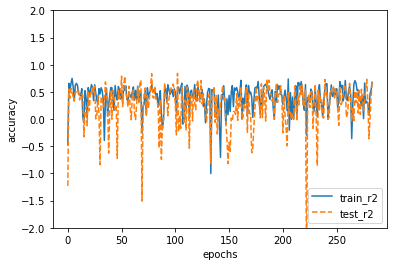

In [27]:
markers = {'train':'o', 'test':'s'}
x = np.arange(len(train_r2_list))
plt.plot(x,train_r2_list, label='train_r2')
plt.plot(x, test_r2_list, label='test_r2', linestyle='--')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.ylim(-2,2)
plt.legend(loc='lower right')
# plt.show()

plt.savefig('./epochs.png')

### Evaluation of System, Test set

Error : A column-vector y was passed

In [28]:
# ValueError: Expected 2D array, got 1D array instead:

flyash_labels = flyash_labels.reshape(-1,1)
y_test = y_test.reshape(-1,1)

In [29]:
y_test_scaled = np.ravel(y_test_scaled)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=['Al2O3', 'CaO', 'Fe2O3', 'SiO2', 'MgO', 'Na2O+0.658K2O', 'SiO2/Al2O3'])

y_test_scaled = pd.DataFrame(y_test_scaled)
flyash_labels_scaled = pd.DataFrame(flyash_labels_scaled)
train_predictions = pd.DataFrame(train_predictions)
test_predictions = pd.DataFrame(test_predictions)

In [30]:
def mape(y_pred, y):
    return np.mean(np.abs((y_pred - y) / y)) * 100

final_model = grid_search.best_estimator_
train_predictions = final_model.predict(flyash_scaled)
test_predictions = final_model.predict(X_test_scaled)

r2_train = r2_score(train_predictions, flyash_labels_scaled)
r2_test = r2_score(test_predictions, y_test_scaled)

In [31]:
print("Train set(85%)")
print("R^2", (r2_train))
# print("MAPE", mape(train_predictions, flyash_labels_scaled))
print("========================")
print("Test set(15%)")
print("R^2", (r2_test))
# print("MAPE", mape(test_predictions, y_test_scaled))

Train set(85%)
R^2 0.6249918538837401
Test set(15%)
R^2 0.6740585539383853


### Analysis

Back to before scaling

In [32]:
flyash_labels_inverse = scalery.inverse_transform(flyash_labels_scaled)
y_test_inverse = scalery.inverse_transform(y_test_scaled)

In [35]:
train_predictions = train_predictions.reshape(-1,1)
test_predictions = test_predictions.reshape(-1,1)

In [36]:
train_predictions_inverse = scalery.inverse_transform(train_predictions)
test_predictions_inverse = scalery.inverse_transform(test_predictions)

Graph

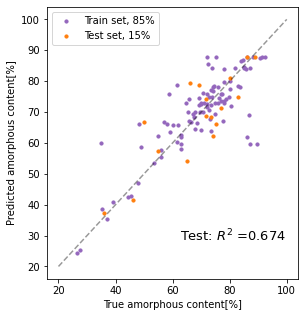

In [37]:
fig, ax = plt.subplots(figsize=(4.5,5))
ax.scatter(flyash_labels_inverse, train_predictions_inverse, color='C4', label='Train set, 85%', s=10)
ax.scatter(y_test_inverse, test_predictions_inverse, color='C1', label='Test set, 15%', s=10)

# y=x dashed line
ax.plot([20,100], [20,100], c="k", linestyle='--',alpha=0.4)

ax.set_xlabel("True amorphous content[%]")
ax.set_ylabel("Predicted amorphous content[%]")
ax.legend(loc="upper left")


ax.text(0.95, 0.14, f"Test: $R^2$ ={r2_test:0.3f}",
        transform=ax.transAxes, fontsize=13, ha="right")

fig.savefig(f"./R2_test.png")

Save Trained Model

In [38]:
# save
joblib.dump(final_model,"./284_100.pkl")

['./284_100.pkl']

## Apply New data (Our Lab's flyashes)

Bring in a Learning Model

In [39]:
final_model = joblib.load("./284_100.pkl")

scalerX = joblib.load("./scalerX.save") 
scalery = joblib.load("./scalery.save")

## model_from_joblib.predict(X)

### New Data

In [40]:
df = pd.read_csv('./new_flyash.csv')
df.drop('ID', axis=1, inplace=True)

# df = df.drop(4, axis=0)  # Aleady remove BIG ash

X_doms = df.iloc[:,0:7]
y_doms = df.iloc[:,7]

## Scailing data
y_doms = y_doms.values.reshape(-1,1)

X_doms_scaled = scalerX.transform(X_doms)
y_doms_scaled = scalery.transform(y_doms)

## Predict data
doms_predictions = final_model.predict(X_doms_scaled)
r2_value = r2_score(y_doms_scaled,doms_predictions)

### Combine graphs

In [41]:
# ValueError: Expected 2D array, got 1D array instead:

doms_predictions = pd.DataFrame(doms_predictions)

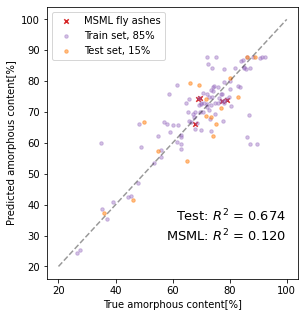

In [44]:
## Return before scailing
y_doms_inverse = scalery.inverse_transform(y_doms_scaled)
doms_predictions_inverse = scalery.inverse_transform(doms_predictions)

## Figure
fig, ax = plt.subplots(figsize=(4.5,5))
ax.scatter(y_doms_inverse, doms_predictions_inverse, color='C3', label='MSML fly ashes', s = 20, marker = 'x')
ax.scatter(flyash_labels_inverse, train_predictions_inverse, color='C4', label='Train set, 85%', s=12, alpha=0.4)
ax.scatter(y_test_inverse, test_predictions_inverse, color='C1', label='Test set, 15%', s=12, alpha=0.5)

ax.plot([20,100], [20,100], c="k", linestyle='--',alpha=0.4) # y=x dashed line

ax.set_xlabel("True amorphous content[%]")
ax.set_ylabel("Predicted amorphous content[%]")
ax.legend(loc="upper left")

# $Test: R^2 ={r2_test:0.3f}$
ax.text(0.95, 0.14, f"Test: $R^2$ = {r2_test:0.3f}\nMSML: $R^2$ = {r2_value:0.3f}", 
        transform=ax.transAxes, fontsize=13, ha="right")

fig.savefig(f"./R2_MSML.png")

In [43]:
df.describe().to_csv('new_describe().csv')